In [1]:
import os
import re
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

from impedance import preprocessing
from impedance.models.circuits.circuits import CustomCircuit
from impedance.visualization import plot_nyquist

import analyze_comsol as an_com

%reload_ext autoreload
%autoreload 2

In [113]:
file_dir = r"A:\BrianGerwe\Research\COMSOL\PatternedFilm_Potentiodynamic\3D\Table Exports\NoHole_Pinholes"

# We need to treat data flagged "N-0" differently, since they represent a film without a mask
# Therefore the impedance is calculated a little different in COMSOL
G = r"\G-100"
N = '' #r"_N-5"
k = '' #'k-5'
r_h = r"r-5e-3L"
f_res = r"10pt-dec"
M = "M-0_01L"
pO2 = '' #"_pO2-0_01"

all_files = an_com.get_all_files(file_dir, G, N, k, r_h, f_res, M, pO2)
all_files

['A:\\BrianGerwe\\Research\\COMSOL\\PatternedFilm_Potentiodynamic\\3D\\Table Exports\\NoHole_Pinholes\\G-100_N-15_k-1_r-5e-3L_f-[1e-3,1e8]_10pt-dec_M-0_01L_pO2-0_01_3.csv',
 'A:\\BrianGerwe\\Research\\COMSOL\\PatternedFilm_Potentiodynamic\\3D\\Table Exports\\NoHole_Pinholes\\G-100_N-15_k-1_r-5e-3L_f-[1e-3,1e8]_10pt-dec_M-0_01L_pO2-0_01.csv',
 'A:\\BrianGerwe\\Research\\COMSOL\\PatternedFilm_Potentiodynamic\\3D\\Table Exports\\NoHole_Pinholes\\G-100_N-5_k-10_r-5e-3L_f-[1e-3,1e8]_10pt-dec_M-0_01L_pO2-0_01.csv',
 'A:\\BrianGerwe\\Research\\COMSOL\\PatternedFilm_Potentiodynamic\\3D\\Table Exports\\NoHole_Pinholes\\G-100_N-15_k-1_r-5e-3L_f-[1e-3,1e8]_10pt-dec_M-0_01L_pO2-0_01_2.csv',
 'A:\\BrianGerwe\\Research\\COMSOL\\PatternedFilm_Potentiodynamic\\3D\\Table Exports\\NoHole_Pinholes\\G-100_N-15_k-1_r-5e-3L_f-[1e-3,1e8]_10pt-dec_M-0_01L_1pO2-0_01.csv',
 'A:\\BrianGerwe\\Research\\COMSOL\\PatternedFilm_Potentiodynamic\\3D\\Table Exports\\NoHole_Pinholes\\G-100_N-5_k-5_r-5e-3L_f-[1e-3,1e8]_10

In [98]:
pd.read_csv(all_files[0], skiprows=4)

,% f,G,# of holes,hole radius,interface mesh max size,randomness,impedance from MC holes (s^3/(kg*m^2)),impedance from LT holes (s^3/(kg*m^2)),Z Error (1),impedance from LT edge (s^3/(kg*m^2)),...,"ionic current out of LT through, ndflux (W)",ionic current out of MC through surface (W),ionic current into LT through bottom edge (W),ionic current out of MC through sides (W),ionic current out of LT through sides (W),accumulation in MC bulk (m^3*K),charge accumulation in LT (m*K),min_hole_dist,mask_height,null_edge_frac
0,0.000000e+00,100,5,0.005,0.001587,5,3.7513456223802577,3.730413687188111,-0.561116,3.730482729143778,...,-2.618829592594825E-6,0.9536470633665826,0.9591646440350385,4.6954200134255134E-5,-6.186489325238293E-6,0,-0.0017770621487890822,0.5,0.0063,0.1
1,1.000000e-03,100,5,0.005,0.001587,5,3.7514027198180897-0.0018838398628335967i,3.730442817163714-0.001873808141571933i,-0.561861,3.730438787250344-0.001873452595637747i,...,-1.67036495379952E-8+1.3341643746028016E-6i,0.9536031559735724-0.014218527602139321i,0.9591757003911002+4.8170478274886356E-4i,9.133650381946568E-6-1.1333180594414526E-6i,1.0314763775318289E-7+3.2473253757740093E-7i,-2.128126942182778E-4-0.014047718053654255i,-0.0017714958816335991-1.0580284115394271E-6i,0.5,0.0063,0.1
2,1.258925e-03,100,5,0.005,0.001587,5,3.7514027198180413-0.0018838399020689105i,3.73044281716376-0.0018738081415719406i,-0.561861,3.7304387872490787-0.0018734525956364766i,...,-1.6703466143149392E-8+1.3341643746028734E-6i,0.9535942919418479-0.014803899978296215i,0.9591757003914255+4.8170478274886356E-4i,8.533082361919984E-6-3.7392349171354086E-5i,1.0314834628000732E-7+3.2473253757766224E-7i,-2.679153087037716E-4-0.01768502923546503i,-0.0017714958816334916-1.0580284115367035E-6i,0.5,0.0063,0.1
3,1.584893e-03,100,5,0.005,0.001587,5,3.7514027198179893-0.0018838399514632526i,3.7304428171637625-0.0018738081415719044i,-0.561861,3.7304387872490787-0.0018734525956364766i,...,-1.6703466617087736E-8+1.3341643746028569E-6i,0.9535831327870486-0.015540840138002339i,0.9591757003914255+4.8170478274886356E-4i,7.777012018283092E-6-8.303976484517868E-5i,1.0314834627538146E-7+3.2473253757766224E-7i,-3.3728539033585754E-4-0.022264132712849702i,-0.001771495881633426-1.0580284115335633E-6i,0.5,0.0063,0.1
4,1.995262e-03,100,5,0.005,0.001587,5,3.7514027198179267-0.0018838400136470504i,3.730442817163763-0.0018738081415718673i,-0.561861,3.7304387872490787-0.0018734525956364766i,...,-1.670346660474213E-8+1.3341643746029335E-6i,0.9535690842434847-0.01646859283202772i,0.9591757003914255+4.8170478274886356E-4i,6.825175853660392E-6-1.405064564198079E-4i,1.0314834587523865E-7+3.2473253757743667E-7i,-4.2461714892072554E-4-0.028028882443764336i,-0.001771495881633426-1.0580284115308054E-6i,0.5,0.0063,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,3.981072e+07,100,5,0.005,0.001587,5,0.5591155393036986-0.14788957213199097i,0.5592789296211043-0.13958820463343172i,-0.331061,0.5592810624829363-0.13958853784839664i,...,1.009103514253955E-5-1.335543320607645E-6i,2.002354749072774E-12-2.2857492807978105E-13i,6.0225963858076+1.5031537449412038i,2.524289085095079E-19+2.8481845621171497E-19i,3.4488291524909596E-6-1.1233456375349851E-6i,-5.981159329181381-1.582002723036708i,-0.010390983631151169-0.007253404786271617i,0.5,0.0063,0.1
108,5.011872e+07,100,5,0.005,0.001587,5,0.5425371270485237-0.13544203360782758i,0.5433705096082536-0.12567532282960656i,-0.264127,0.5433725541354547-0.12567639871850303i,...,1.1198561862343801E-5-2.585451207736265E-6i,1.478114596888079E-13-9.995705832280236E-13i,6.250691657357287+1.4457197203240144i,2.608050484486305E-19-1.2574165372755184E-19i,3.5245599017072914E-6-1.3676783297151185E-6i,-6.208212472168213-1.5498840457297332i,-0.01104936860455062-0.008237020269901092i,0.5,0.0063,0.1
109,6.309573e+07,100,5,0.005,0.001587,5,0.5273580645424065-0.12466856731387557i,0.5290004744822956-0.11313959302032495i,-0.171856,0.5290018306967239-0.11314054657467118i,...

G-100_N-15_k-1_r-5e-3L_f-[1e-3,1e8]_10pt-dec_M-0_01L_pO2-0_01.csv
# of holes                    15
randomness                     1
Pinhole Area (m^2)    0.00793806
Name: 0, dtype: object
Filtered 1 data points with positive Im[Z]
Peak frequencies: 1258925.4117941658

Circuit string: R0-p(R1,CPE1)-p(R2,C2)
Fit: True

Initial guesses:
     R0 = 3.85e-01 [Ohm]
     R1 = 2.47e+00 [Ohm]
  CPE1_0 = 5.12e-08 [Ohm^-1 sec^a]
  CPE1_1 = 8.00e-01 []
     R2 = 1.60e-01 [Ohm]
     C2 = 1.25e+01 [F]

Fit parameters:
     R0 = 3.64e-01  (+/- 5.45e-03) [Ohm]
     R1 = 2.48e+00  (+/- 6.09e-03) [Ohm]
  CPE1_0 = 3.16e-06  (+/- 1.37e-07) [Ohm^-1 sec^a]
  CPE1_1 = 7.41e-01  (+/- 2.90e-03) []
     R2 = 1.61e-01  (+/- 3.94e-03) [Ohm]
     C2 = 8.83e+00  (+/- 6.09e-01) [F]

G-100_N-5_k-10_r-5e-3L_f-[1e-3,1e8]_10pt-dec_M-0_01L_pO2-0_01.csv
# of holes                    5
randomness                   10
Pinhole Area (m^2)    0.0372534
Name: 0, dtype: object
Filtered 1 data points with positive Im[Z]
Peak frequ

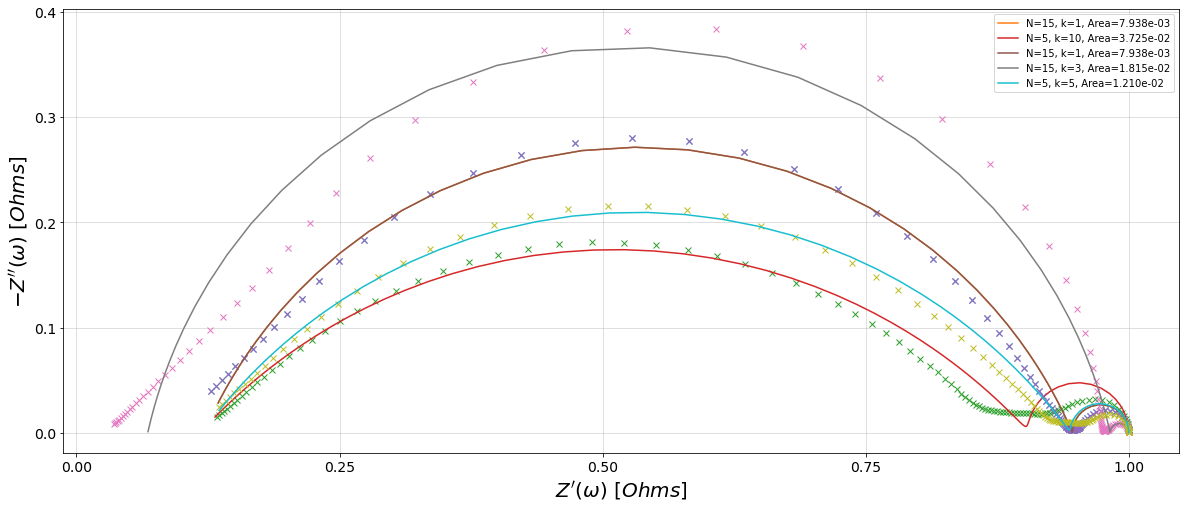

In [125]:
_, ax = plt.subplots(figsize=(20,15))
fs, Zs, circs = [], [], []

for i, file in enumerate(all_files[1:]):
    print(file.split('holes\\')[-1])
    dum = pd.read_csv(file, skiprows=4)
    
    feats = dum.loc[0, ['# of holes', 'randomness', 'Pinhole Area (m^2)']]
    print(feats)
#     dat = pd.read_csv(file, skiprows=4)
    ax, f, Z, circ = an_com.fit_R_RCPE_RC(file, ax, ind=f'N={feats[0]}, k={feats[1]}, Area={feats[2]:.3e}', scale=True)
#      print(i, file.split("holes\\")[-1])
#     f, Z = an_com.extract_plot_Z_scaled(file, ax, i)
#     plot_nyquist(ax, Z/Z[-1], label=i)
    print(f'Peak frequencies: {f[np.argmin(Z.imag)]}')
    print(circ)

    fs.append(f)
    Zs.append(Z)
    circs.append(circ)

plt.legend()
plt.show()

## More refined fitting than R-R//CPE-R

Peak frequencies: [1.25892541e+06 7.94328235e-02]

Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)-G3
Fit: True

Initial guesses:
     R0 = 3.85e-01 [Ohm]
     R1 = 2.47e+00 [Ohm]
  CPE1_0 = 5.12e-08 [Ohm^-1 sec^a]
  CPE1_1 = 7.00e-01 []
     R2 = 7.99e-02 [Ohm]
  CPE2_0 = 2.51e+01 [Ohm^-1 sec^a]
  CPE2_1 = 5.00e-01 []
   G3_0 = 7.99e-02 [Ohm]
   G3_1 = 2.34e+00 [sec]

Fit parameters:
     R0 = 2.61e-01  (+/- 3.92e-03) [Ohm]
     R1 = 1.66e+00  (+/- 3.00e-02) [Ohm]
  CPE1_0 = 6.81e-07  (+/- 2.62e-08) [Ohm^-1 sec^a]
  CPE1_1 = 8.66e-01  (+/- 3.60e-03) []
     R2 = 9.32e-01  (+/- 2.68e-02) [Ohm]
  CPE2_0 = 5.15e-04  (+/- 7.20e-05) [Ohm^-1 sec^a]
  CPE2_1 = 4.63e-01  (+/- 7.95e-03) []
   G3_0 = 1.62e-01  (+/- 7.58e-04) [Ohm]
   G3_1 = 3.92e+00  (+/- 6.56e-02) [sec]



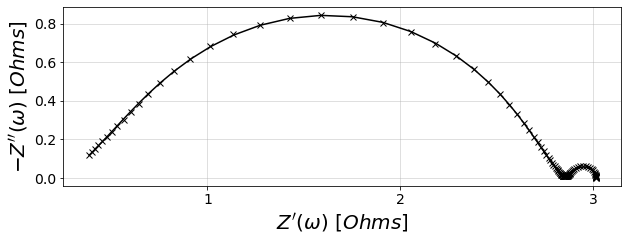

In [126]:
Z_dum = Zs[0]
f_dum = fs[0]

circ_str = "R0-p(R1,CPE1)-p(R2,CPE2)-G3"

peak_inds = signal.find_peaks(-Z_dum.imag)[0]

print(f'Peak frequencies: {f_dum[peak_inds]}')
R1_ind = peak_inds[0]+np.argmax(Z_dum[peak_inds[0]:peak_inds[1]].imag)
R1_init = Z_dum[R1_ind].real - Z_dum[0].real

f_1 = f_dum[peak_inds[0]]
CPE1_init = 1 / (2 * np.pi * f_1 * R1_init)

R2_init = (Z_dum[-1].real - Z_dum[R1_ind].real)/2

f_2 = f_dum[peak_inds[1]]
CPE2_init = 1 / (2 * np.pi * f_2 * R2_init)

inits = [Z_dum[0].real, R1_init, CPE1_init, 0.7, R2_init, CPE2_init, 0.5, R2_init, 2.344]

circ = CustomCircuit(circ_str, initial_guess = inits)
circ.fit(f_dum, Z_dum)

print(circ)

_, ax = plt.subplots(figsize=(10, 7))

plot_nyquist(ax, Z_dum, fmt='kx')
plot_nyquist(ax, circ.predict(f_dum), fmt='k')

plt.show()

Filtered 1 data points with positive Im[Z]


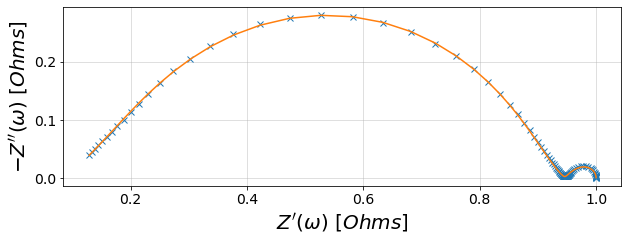


Circuit string: R0-p(R1,CPE1)-p(R2,CPE2)-G3
Fit: True

Initial guesses:
     R0 = 3.86e-01 [Ohm]
     R1 = 2.47e+00 [Ohm]
  CPE1_0 = 5.13e-08 [Ohm^-1 sec^a]
  CPE1_1 = 8.00e-01 []
     R2 = 7.98e-02 [Ohm]
  CPE2_0 = 2.51e+01 [Ohm^-1 sec^a]
  CPE2_1 = 8.00e-01 []
   G3_0 = 7.98e-02 [Ohm]
   G3_1 = 2.34e+00 [sec]

Fit parameters:
     R0 = 2.63e-01  (+/- 3.85e-03) [Ohm]
     R1 = 1.65e+00  (+/- 3.00e-02) [Ohm]
  CPE1_0 = 6.81e-07  (+/- 2.62e-08) [Ohm^-1 sec^a]
  CPE1_1 = 8.67e-01  (+/- 3.60e-03) []
     R2 = 9.31e-01  (+/- 2.68e-02) [Ohm]
  CPE2_0 = 5.09e-04  (+/- 7.11e-05) [Ohm^-1 sec^a]
  CPE2_1 = 4.64e-01  (+/- 7.92e-03) []
   G3_0 = 1.62e-01  (+/- 7.53e-04) [Ohm]
   G3_1 = 3.92e+00  (+/- 6.52e-02) [sec]



In [135]:
Z_dum = Zs[0]
f_dum = fs[0]

_, ax = plt.subplots(figsize=(10,7))

_,_, circ = an_com.fit_R_RCPE_RCPE_G(all_files[0], ax, 2.344, scale=True, return_ax=False)

print(circ)

In [ ]:
R0_init = Zs[0].real

f1 = f_n0[np.argmin(Z_n0.imag)]
R1_init = (Z_n0[-1] - Z_n0[0]).real
C1_init = 1 / (2 * np.pi * f1 * R1_init)

inits = [R0_init, R1_init, C1_init]
print(inits, '\n', f1)
circ = CustomCircuit(circuit=circ_str, initial_guess=inits)
circ.fit(f_n0, Z_n0)
print(circ)

In [58]:
signal.find_peaks(-Zs[0].imag)

(array([29, 91], dtype=int64), {})

In [56]:
print(circs[0])


Circuit string: R0-p(R1,CPE1)-p(R2,C2)
Fit: True

Initial guesses:
     R0 = 2.80e-01 [Ohm]
     R1 = 1.63e+00 [Ohm]
  CPE1_0 = 7.75e-07 [Ohm^-1 sec^a]
  CPE1_1 = 5.00e-01 []
     R2 = 1.77e-01 [Ohm]
     C2 = 1.13e+01 [F]

Fit parameters:
     R0 = 2.43e-01  (+/- 6.20e-03) [Ohm]
     R1 = 1.63e+00  (+/- 7.76e-03) [Ohm]
  CPE1_0 = 5.01e-04  (+/- 3.01e-05) [Ohm^-1 sec^a]
  CPE1_1 = 5.30e-01  (+/- 4.86e-03) []
     R2 = 1.95e-01  (+/- 5.08e-03) [Ohm]
     C2 = 3.98e+00  (+/- 2.94e-01) [F]



In [20]:
file_dir = r"A:\BrianGerwe\Research\COMSOL\PatternedFilm_Potentiodynamic\3D\Table Exports\NoHole_Pinholes"

# We need to treat data flagged "N-0" differently, since they represent a film without a mask
# Therefore the impedance is calculated a little different in COMSOL
G = r"\G-100"
N = r"_N-5"
r_h = r"r-5e-3L"
f_res = r"10pt-dec"
pO2 = "_pO2-0_01"

match_str = G + N + "*" + r_h + "*" + pO2 + "*.csv"   #"_N-[1-9]*10pt-dec_1p*.csv"
all_files = glob.glob(file_dir + match_str)
all_files.sort(key=lambda x: x.split("_N-")[-1].split("_")[0])

match_str_n0 = G + "_N-0" + pO2 + "*.csv"
n0_file = glob.glob(file_dir+G+"_N-0*10pt-dec_p*.csv")

In [21]:
all_files

['A:\\BrianGerwe\\Research\\COMSOL\\PatternedFilm_Potentiodynamic\\3D\\Table Exports\\NoHole_Pinholes\\G-100_N-5_k-10_r-5e-3L_f-[1e-3,1e8]_10pt-dec_M-0_01L_pO2-0_01.csv',
 'A:\\BrianGerwe\\Research\\COMSOL\\PatternedFilm_Potentiodynamic\\3D\\Table Exports\\NoHole_Pinholes\\G-100_N-5_k-0_r-5e-3L_f-[1e-3,1e8]_10pt-dec_pO2-0_01.csv',
 'A:\\BrianGerwe\\Research\\COMSOL\\PatternedFilm_Potentiodynamic\\3D\\Table Exports\\NoHole_Pinholes\\G-100_N-5_k-10_r-5e-3L_f-[1e-3,1e8]_10pt-dec_pO2-0_01.csv',
 'A:\\BrianGerwe\\Research\\COMSOL\\PatternedFilm_Potentiodynamic\\3D\\Table Exports\\NoHole_Pinholes\\G-100_N-5_k-1_r-5e-3L_f-[1e-3,1e8]_10pt-dec_pO2-0_01.csv']

# Scratch!!

Processing A:\BrianGerwe\Research\COMSOL\PatternedFilm_Potentiodynamic\3D\Table Exports\NoHole_Pinholes\G-100_N-5_k-10_r-5e-3L_f-[1e-3,1e8]_10pt-dec_M-0_01L_pO2-0_01.csv

Filtered 1 data points with positive Im[Z]

Circuit string: R0-p(R1,CPE1)-p(R2,C2)
Fit: True

Initial guesses:
     R0 = 2.80e-01 [Ohm]
     R1 = 1.63e+00 [Ohm]
  CPE1_0 = 7.75e-07 [Ohm^-1 sec^a]
  CPE1_1 = 5.00e-01 []
     R2 = 1.77e-01 [Ohm]
     C2 = 1.13e+01 [F]

Fit parameters:
     R0 = 2.43e-01  (+/- 6.20e-03) [Ohm]
     R1 = 1.63e+00  (+/- 7.76e-03) [Ohm]
  CPE1_0 = 5.01e-04  (+/- 3.01e-05) [Ohm^-1 sec^a]
  CPE1_1 = 5.30e-01  (+/- 4.86e-03) []
     R2 = 1.95e-01  (+/- 5.08e-03) [Ohm]
     C2 = 3.98e+00  (+/- 2.94e-01) [F]

Processing A:\BrianGerwe\Research\COMSOL\PatternedFilm_Potentiodynamic\3D\Table Exports\NoHole_Pinholes\G-100_N-5_k-0_r-5e-3L_f-[1e-3,1e8]_10pt-dec_pO2-0_01.csv

Filtered 15 data points with positive Im[Z]

Circuit string: R0-p(R1,CPE1)-p(R2,C2)
Fit: True

Initial guesses:
     R0 = 2.21e+00

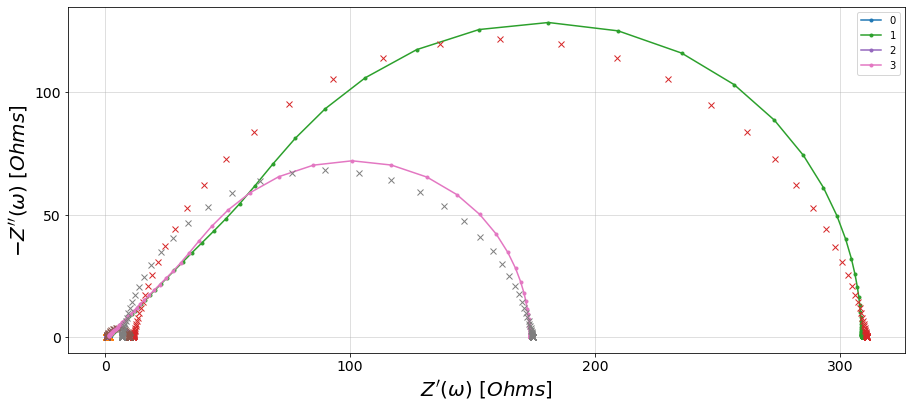

In [22]:
fs, Zs, circs = [], [], []

_, ax = plt.subplots(figsize=(15,10))

for i, file in enumerate(all_files):
    ax, f, Z, circ = an_com.process_n(file, ax, ind=i, return_Z=True, return_ax=True)
        
    fs.append(f)
    Zs.append(Z)
    circs.append(circ)
    print(circ)
ax.legend()
# ax.set_xlim(5,6)
plt.show()

In [12]:
Z

array([0.87441-0.054129j , 0.88138-0.058252j , 0.88882-0.062974j ,
       0.89683-0.068362j , 0.9055 -0.074485j , 0.91492-0.081422j ,
       0.92521-0.089261j , 0.93649-0.0981j   , 0.94889-0.10805j  ,
       0.96258-0.11922j  , 0.97772-0.13174j  , 0.99452-0.14573j  ,
       1.0132 -0.16133j  , 1.034  -0.17867j  , 1.0572 -0.19788j  ,
       1.083  -0.21911j  , 1.1118 -0.2425j   , 1.144  -0.26819j  ,
       1.1798 -0.29633j  , 1.2199 -0.32702j  , 1.2645 -0.36035j  ,
       1.3143 -0.39637j  , 1.3698 -0.43508j  , 1.4315 -0.47639j  ,
       1.5002 -0.52015j  , 1.5763 -0.56605j  , 1.6607 -0.61364j  ,
       1.7537 -0.6623j   , 1.856  -0.71117j  , 1.9678 -0.75922j  ,
       2.0892 -0.80516j  , 2.2201 -0.84754j  , 2.3597 -0.88484j  ,
       2.5068 -0.91557j  , 2.6601 -0.93841j  , 2.8175 -0.95239j  ,
       2.977  -0.95693j  , 3.1362 -0.95195j  , 3.293  -0.93779j  ,
       3.4454 -0.91523j  , 3.5918 -0.88534j  , 3.7308 -0.84936j  ,
       3.8616 -0.80866j  , 3.9836 -0.76455j  , 4.0966 -0.71828

In [12]:
ax.set_xlim(5,6)
plt.show()


Circuit string: R0-p(R1,CPE1),G2
Fit: True

Initial guesses:
     R0 = 8.46e-01 [Ohm]
     R1 = 4.31e+00 [Ohm]
  CPE1_0 = 4.06e-05 [Ohm^-1 sec^a]
  CPE1_1 = 5.23e-01 []
   G2_0 = 2.00e-01 [Ohm]
   G2_1 = 2.34e+00 [sec]

Fit parameters:
     R0 = 8.54e-01  (+/- 2.92e-01) [Ohm]
     R1 = 4.35e+00  (+/- 4.59e+02) [Ohm]
  CPE1_0 = 4.02e-05  (+/- 3.20e+00) [Ohm^-1 sec^a]
  CPE1_1 = 5.18e-01  (+/- 3.87e+04) []
   G2_0 = 1.00e+00  (+/- 2.33e+01) [Ohm]
   G2_1 = 3.44e-01  (+/- 7.31e+00) [sec]



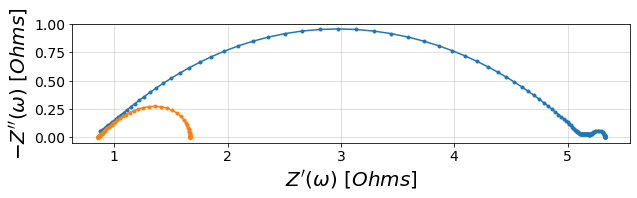

In [18]:
circ_str = "R0-p(R1,CPE1),G2"
params = circ.parameters_
inits=[params[0], params[1], params[2], params[3], .2, 2.344]

lbs = [params[0]*.99, params[1]*.99, params[2]*.99, params[3]*.99, .1, 0.344]
ubs = [params[0]*1.01, params[1]*1.01, params[2]*1.01, params[3]*1.01, 1, 4.344]
circ2 = CustomCircuit(circuit=circ_str, initial_guess=inits)
circ2.fit(f, Z, bounds=(lbs,ubs))
print(circ2)

_, ax2 = plt.subplots(figsize=(10,7))

plot_nyquist(ax2, Z)
plot_nyquist(ax2, circ2.predict(f))

plt.show()

In [5]:
circ.parameters_

array([8.45509517e-01, 4.30891835e+00, 4.06113758e-05, 5.23324503e-01,
       1.65949608e-01, 6.39075525e+00])